In [0]:
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer 
from random import sample, seed
from nltk.corpus import wordnet as wn
import gensim
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt  # For plotting
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from tqdm import notebook as tq
from nltk.stem import PorterStemmer 
from collections import OrderedDict

In [2]:
!apt-get install python3-dev graphviz libgraphviz-dev pkg-config

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
The following additional packages will be installed:
  libgvc6-plugins-gtk libxdot4
The following NEW packages will be installed:
  libgraphviz-dev libgvc6-plugins-gtk libxdot4
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 91.3 kB of archives.
After this operation, 425 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libxdot4 amd64 2.40.1-2 [15.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgvc6-plugins-gtk amd64 2.40.1-2 [18.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgraphviz-dev amd64 2.40.1-2 [57.3 kB]
Fetched 91.3 kB in 1s (173 kB/s)
Selecting previously unselected package libxdot4.
(Readi

In [3]:
pip install pygraphviz

     |████████████████████████████████| 122kB 2.7MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.5-cp36-cp36m-linux_x86_64.whl size=157580 sha256=02141997cbf18817144efce62895e92cb1ea2ab0fda86500d339b3f2367985a4
  Stored in directory: /root/.cache/pip/wheels/65/54/69/1aee9e66ab19916293208d4c9de0d3898adebe6b2eeff6476b
Successfully built pygraphviz


In [4]:
import nltk
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('drive/My Drive/NLP_Data/GoogleNews-vectors-negative300.bin', binary=True)  

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def wn_tree(word):
  '''
  Parameters:
  word: a wordnet synset object
  Returns: 
  Graph with one level above the word (hypernyms) and one level below (hyponyms)
  '''
  seen = set()
  G = nx.Graph()

  for h in word.hypernyms():
    if (h.name().split('.')[0] in model.vocab) and (h not in seen):
      seen.add(h)
      for hypo in h.hyponyms():
        if (hypo.name().split('.')[0] in model.vocab) and (hypo not in seen):
          seen.add(hypo)
          G.add_node(h.name().split('.')[0])
          G.add_node(hypo.name().split('.')[0])
          G.add_edge(h.name().split('.')[0], hypo.name().split('.')[0])
          for sub_hypo in hypo.hyponyms():
            if (sub_hypo.name().split('.')[0] in model.vocab) and (sub_hypo not in seen):
              seen.add(sub_hypo)
              G.add_node(sub_hypo.name().split('.')[0])
              G.add_edge(hypo.name().split('.')[0], sub_hypo.name().split('.')[0])
  return G

In [0]:
lemmatizer = WordNetLemmatizer()
def random_wn_tree(wList):
  word_num=0
  while word_num<=1:
    w=sample(words.words(), 1)
    lem=lemmatizer.lemmatize(w[0])
    word_net=wn.synsets(lem)
    if (len(word_net)!=0) and (lem in model.vocab):
      wn_find=word_net[0]
      if wn_find not in wList:
        g=wn_tree(wn_find)
        if len(g.edges())>=10:
          word_num+=1
  return wn_find, g # random wordnet tree

In [0]:
def w2v_tree(g):
  G=nx.Graph()
  node_dict={}
  edge_weights=[]

  w2vec=np.stack([model[n] for n in g.nodes()], axis=0)
  similarity=np.round(1-pairwise_distances(w2vec, metric="cosine"),4)
  
  for i, n in enumerate(g.nodes()):
    node_dict[i]=n
  for i, n in enumerate(similarity):
    for j, n in enumerate(similarity):
      edge_weights.append((node_dict[j], node_dict[i], similarity[i][j]))

  G.add_weighted_edges_from(edge_weights)
  T=nx.maximum_spanning_tree(G)
  return T

In [0]:
def plt_tree(g, t):
  # nx.draw(g, pos, with_labels=True, node_size=1000)
  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(121)
  ax2 =fig.add_subplot(122)
  plt.sca(ax1)
  node_size=len(g.nodes())
  write_dot(g,'test.dot')
  pos =graphviz_layout(g, prog='dot')
  nx.draw(g, with_labels=True, node_color=range(node_size), cmap=plt.cm.Pastel1, node_size=1000)
  ax1.set_title("Wordnet Tree")

  plt.sca(ax2)
  node_size=len(t.nodes())
  write_dot(t,'test.dot')
  pos =graphviz_layout(t, prog='dot')
  nx.draw(t, with_labels=True, node_color=range(node_size), cmap=plt.cm.Pastel1, node_size=1000)
  ax2.set_title("Word2Vec Tree")

In [0]:
def edge_analysis(g, t):
  intersection=len(nx.intersection(t, g).edges)
  gold=len(g.edges)
  w2v=len(t.edges)
  p=intersection/w2v
  r=intersection/gold
  if (p+r)!=0:
    f=2*(p*r)/(p+r)
  else:
    f=0
  return p, r, f, nx.intersection(t, g).edges


In [0]:
def degree_analysis(g, t):
  k1 = nx.degree_centrality(g)
  k2 = nx.degree_centrality(t)
  diff=[]
  for k, v in k1.items():
    diff.append(abs(v-k2[k]))
  return np.mean(diff), k1, k2

In [0]:
def run_project(n):
  seed(42)
  words, gold_size=[],[]
  p_e, r_e, f_e=[], [], []
  error_d=[]
  for i in tq.tqdm(range(n)):
    w, g=random_wn_tree(words)
    t=w2v_tree(g)

    words.append(w)
    gold_size.append(len(g.edges))

    edge_p, edge_r, edge_f, edge_i=edge_analysis(g,t)
    p_e.append(edge_p)
    r_e.append(edge_r)
    f_e.append(edge_f)

    error, d1, d2=degree_analysis(g, t)
    error_d.append(error)

  print("Unique Words", len(np.unique(words)))
  print("*****************************")
  print("EDGE ANALYSIS")
  print("Average precision for edge:", np.mean(p_e))
  print("Average recall for edge:", np.mean(r_e))
  print("Average f1 score for edge:", np.mean(f_e))
  print("*****************************")
  print("DEGREE ANALYSIS")
  print("Average error of degree centrality:", np.mean(error_d))
  print("*****************************")
  print("SAMPLE ANALYSIS")
  plt_tree(g, t)
  print("Common Edges:", edge_i)
  print("Precision", edge_p)
  print("Recall", edge_r)
  print("F score", edge_f)
  print("\nDegree Centrality of Gold:", d1) 
  print("Degree Centrality of W2V:", d2)
  print("Difference in degree centrality", error) 
  return words, gold_size, p_e, r_e, f_e, error_d, 


Unique Words 1001
*****************************
EDGE ANALYSIS
Average precision for edge: 0.2495541787869524
Average recall for edge: 0.24795248995424793
Average f1 score for edge: 0.24870773234619922
*****************************
DEGREE ANALYSIS
Average error of degree centrality: 0.07672652296726876
*****************************
SAMPLE ANALYSIS
Common Edges: [('inheritance', 'primogeniture'), ('inheritance', 'bequest'), ('inheritance', 'heirloom'), ('inheritance', 'devise')]
Precision 0.6666666666666666
Recall 0.6666666666666666
F score 0.6666666666666666

Degree Centrality of Gold: {'inheritance': 1.0, 'accretion': 0.16666666666666666, 'bequest': 0.16666666666666666, 'birthright': 0.16666666666666666, 'devise': 0.16666666666666666, 'heirloom': 0.16666666666666666, 'primogeniture': 0.16666666666666666}
Degree Centrality of W2V: {'inheritance': 0.6666666666666666, 'accretion': 0.16666666666666666, 'bequest': 0.16666666666666666, 'birthright': 0.16666666666666666, 'devise': 0.16666666

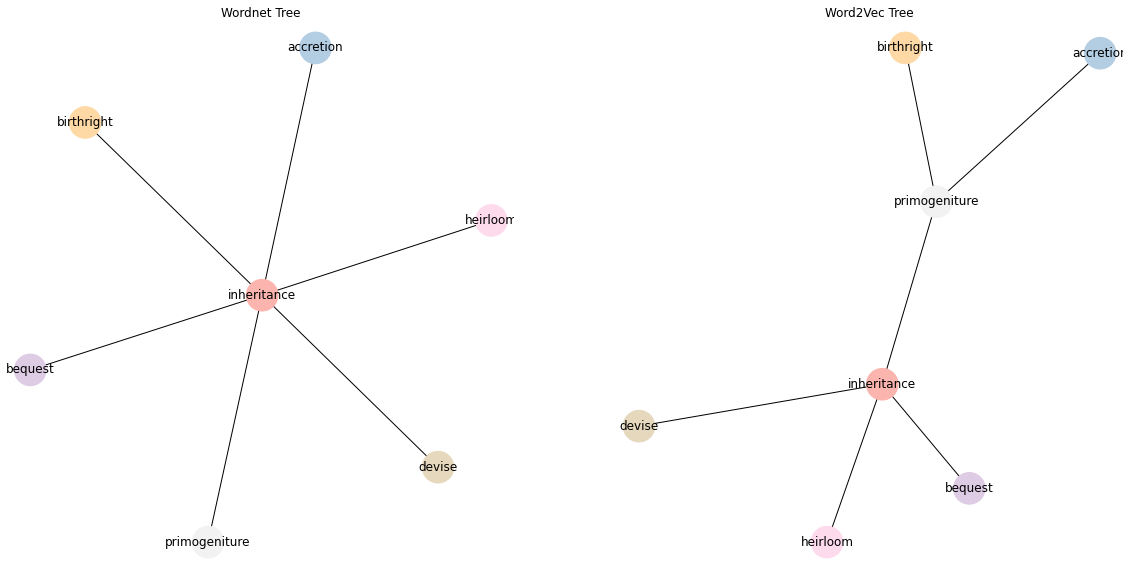

In [51]:
wx, goldx,px, rx, fx, err=run_project(1001)

Text(0.5, 0, 'Number of edges')

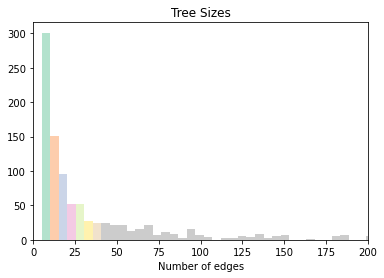

In [147]:
n, bins, patches=plt.hist(goldx, bins=200)
cm = plt.cm.Pastel2
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cm(i)) # notice the i/25
plt.xlim(0, 200)
plt.title("Tree Sizes")
plt.xlabel("Number of edges")

Text(0, 0.5, 'Mean Error of degree centrality')

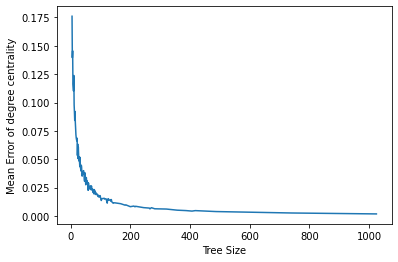

In [149]:
sns.lineplot(goldx, err, ci=None)
plt.xlabel("Tree Size")
plt.ylabel("Mean Error of degree centrality")

Text(0, 0.5, 'Precision of Edges')

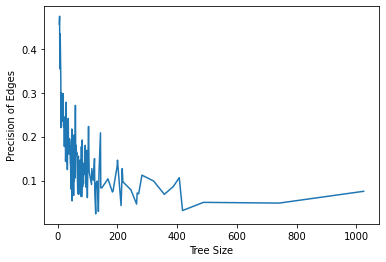

In [154]:
sns.lineplot(goldx, px, ci=None)
plt.xlabel("Tree Size")
plt.ylabel("Precision of Edges")

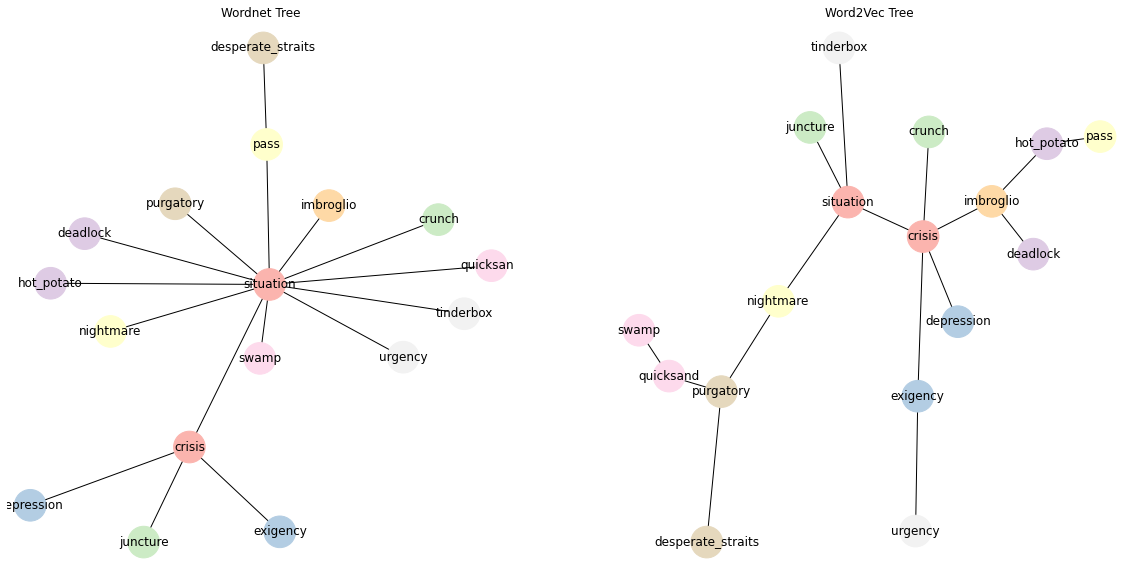

In [0]:
plt_tree(g, t)

In [0]:
node_analysis(g, t)

0.5882352941176471


In [0]:
rank, count, previous, result = 0, 0, None, {}
for key, num in k2:
  count += 1
  if num != previous:
    rank += count
    previous = num
    count = 0
    result[key] = rank

print(result)

{'crisis': 1, 'crunch': 2, 'exigency': 6, 'imbroglio': 8, 'juncture': 9, 'nightmare': 10, 'pass': 11, 'purgatory': 12, 'quicksand': 13, 'situation': 14, 'swamp': 15}


In [0]:
nx.degree(t)

DegreeView({'situation': 4, 'crisis': 5, 'depression': 1, 'exigency': 2, 'juncture': 1, 'crunch': 1, 'deadlock': 1, 'hot_potato': 2, 'imbroglio': 3, 'nightmare': 2, 'pass': 1, 'desperate_straits': 1, 'purgatory': 3, 'quicksand': 2, 'swamp': 1, 'tinderbox': 1, 'urgency': 1})

In [0]:
np.mean([i[1] for i in nx.degree(t)])

1.8823529411764706

In [0]:
d=nx.degree_centrality(g)
np.sum([v for k, v in d.items()])

2.0

In [0]:
for i in nx.degree(t):
  if i[1]>1:
    print(i)

('situation', 4)
('crisis', 5)
('exigency', 2)
('hot_potato', 2)
('imbroglio', 3)
('nightmare', 2)
('purgatory', 3)
('quicksand', 2)


In [0]:
#cluster analysis